In [4]:
import pandas as pd
from dataviz import data_slice,data_slice_year,data_slice_date,data_timeplot
from datetime import datetime, date, timedelta
import matplotlib.pyplot as plt
def savefig(figure, filename, dpi=200):
    for ext in ['png','jpeg','pdf']:
        figure.savefig(f'./figures/{filename}.{ext}', dpi=dpi)

In [5]:

X_train=pd.read_csv('training_input_qFI2jug.csv', index_col="Horodate_UTC",parse_dates=['Horodate_UTC'],dayfirst=True)
feature_list=list(X_train.columns[3:])
#X_train['timestamp']=pd.to_datetime(X_train.index)
X_train.index = pd.DatetimeIndex(X_train.index)

liste_dates = X_train.index.tolist()
for dt in liste_dates :
    X_train.at[dt, 'sort'] = dt.strftime('%m%d%H%S')

X_train['sort'].astype(int)

df_month = X_train.sort_values(by='sort', ascending=True)
df_month.head(20)
df_month = df_month.interpolate(str="linear", axis=0).ffill().bfill()
df = df_month.sort_values(by='IDS', ascending=True)

X_train.drop('sort', axis=1)

X_train['Pseudo rayonnement'] = df['Pseudo rayonnement']
X_train['timestamp']=pd.to_datetime(X_train.index)




In [6]:
X_test=pd.read_csv('testing_input_BcjTmnd.csv',index_col="Horodate_UTC",parse_dates=['Horodate_UTC'],dayfirst=True)
#X_test['timestamp']=pd.to_datetime(X_test.index)
X_test.index = pd.DatetimeIndex(X_test.index)

X_test['timestamp']=pd.to_datetime(X_test.index)

In [7]:
y_train=pd.read_csv('training_output_uamzSZW.csv',index_col="Horodate_UTC",parse_dates=['Horodate_UTC'],dayfirst=True)
#y_train['timestamp']=pd.to_datetime(y_train.index)
y_train.index = pd.DatetimeIndex(y_train.index)

y_train['timestamp']=pd.to_datetime(y_train.index)

# Exploration des séries temporelles

In [8]:
# extraction of RES1_BASE profile untill 30/06/2018
Res1_base=data_slice_date(y_train,date(2013,10,15),date(2016,8,31),['RES1_BASE'])
Res1_base_test=data_slice_date(y_train,date(2016,9,1),date(2016,9,30),['RES1_BASE'])

In [9]:
Res1_base

,RES1_BASE
Horodate_UTC,
2013-10-15 00:00:00,0.587075
2013-10-15 00:30:00,0.593554
2013-10-15 01:00:00,0.576455
2013-10-15 01:30:00,0.551392
2013-10-15 02:00:00,0.566260
...,...
2016-08-30 22:00:00,0.703896
2016-08-30 22:30:00,0.641450
2016-08-30 23:00:00,0.580703


Exploration of seasonality based on 'natural' behavior of energy comsummer daily and weekly periodicity

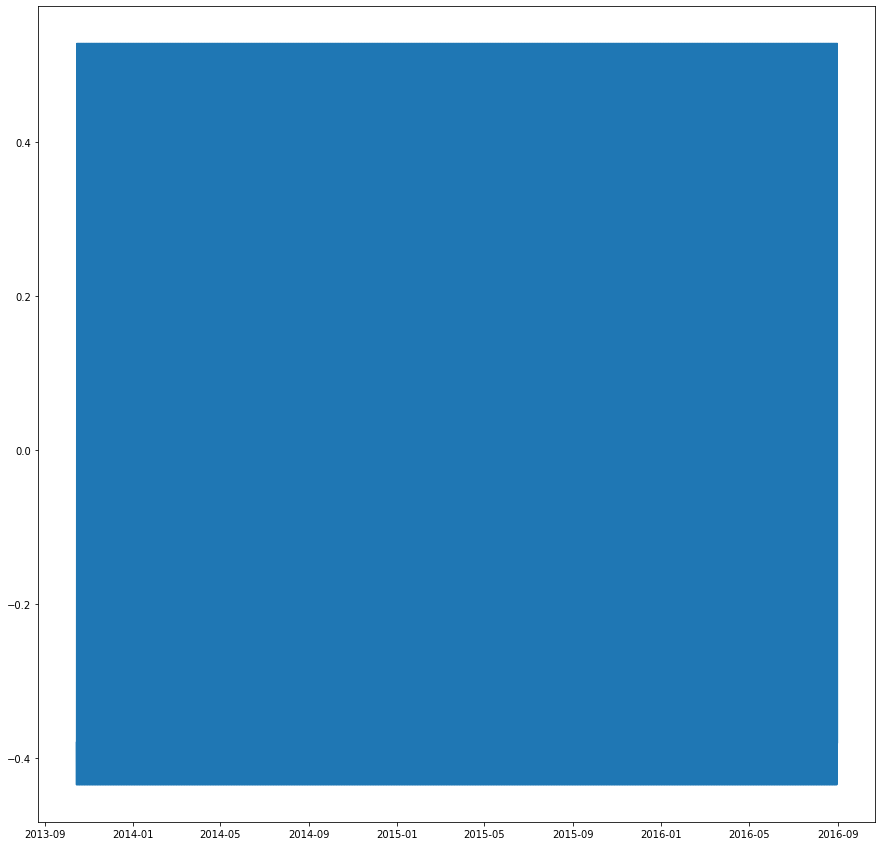

In [10]:
from statsmodels.tsa.seasonal import seasonal_decompose
from pandas.plotting import autocorrelation_plot
# freq = 48 * 30 min = 1 day
Res1_base_seasonal=seasonal_decompose(Res1_base,freq=48)
plt.figure(figsize=(15,15))

plt.plot(Res1_base_seasonal.seasonal)
plt.show()


# this let assume an additive model

Autocorrelation exploration and successive differentitaion with periodicity of 48 (1 day) and 7*48 (1 week)

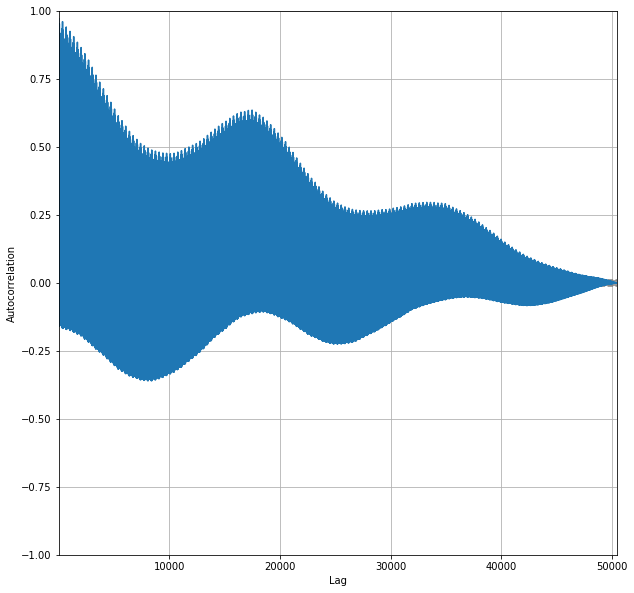

In [11]:
fig=plt.figure(figsize=(10,10))
autocorrelation_plot(Res1_base)
#very slowly decreasing autocorrelation
savefig(fig,'RES1_base_Autocorrelation')

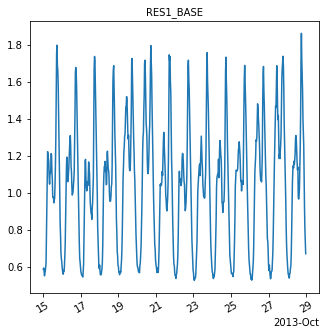

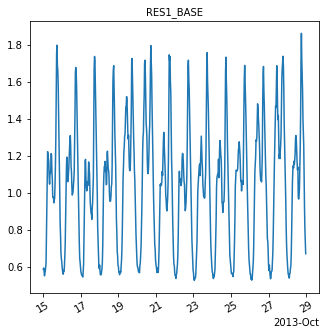

In [12]:
data_timeplot(data_slice(Res1_base,0,14))

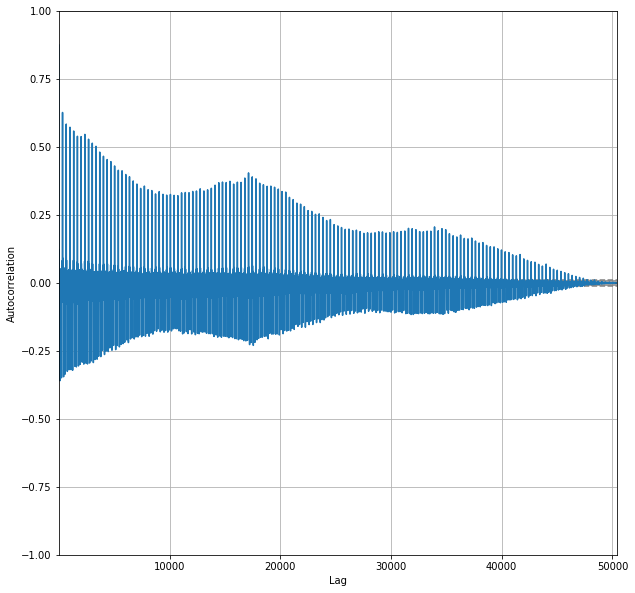

In [13]:
fig=plt.figure(figsize=(10,10))
Res1_base_1d=Res1_base.diff(periods=48).dropna()
autocorrelation_plot(Res1_base_1d)
savefig(fig,'RES1_base1d_Autocorrelation')
# autocorrelation reduced after first differetiation but still significant

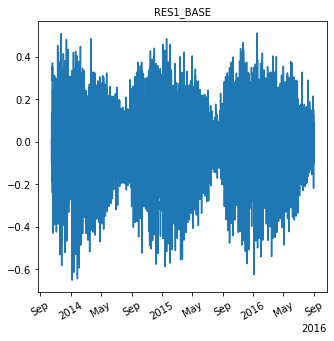

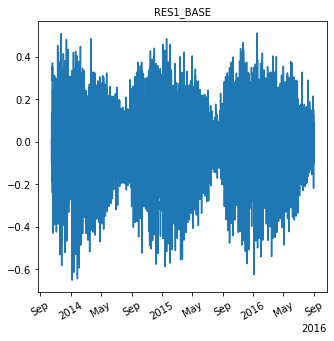

In [14]:
data_timeplot(Res1_base_1d)

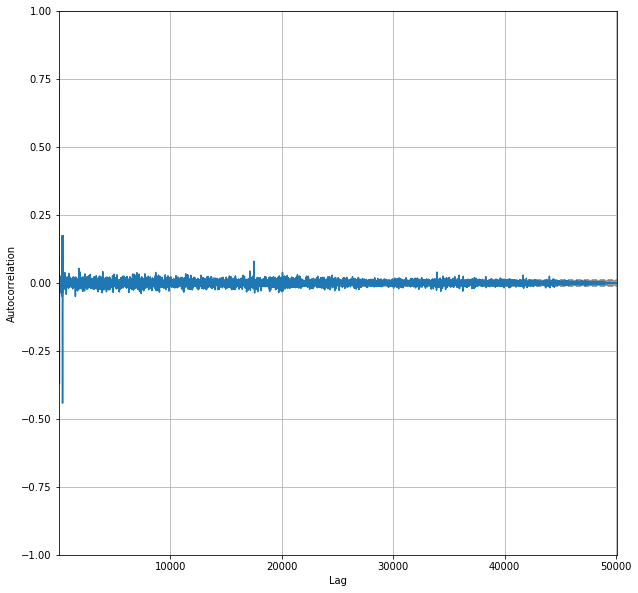

In [15]:
fig=plt.figure(figsize=(10,10))
Res1_base_7d=Res1_base_1d.diff(periods=48*7).dropna()
autocorrelation_plot(Res1_base_7d)
savefig(fig,'RES1_base7d_Autocorrelation')

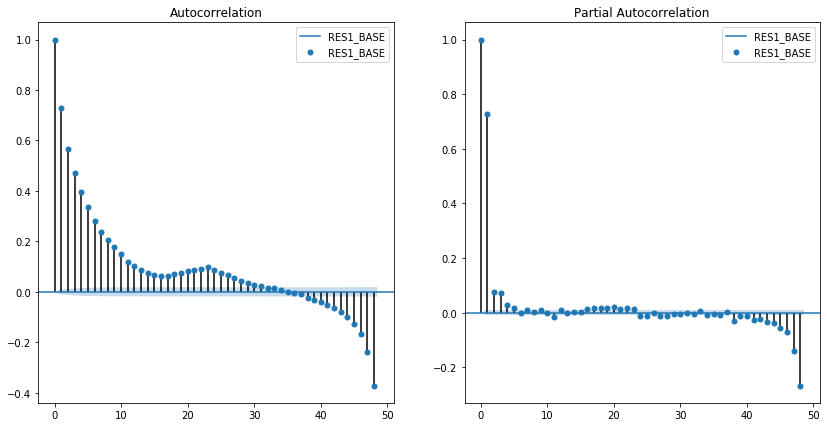

In [50]:
from  statsmodels.graphics.tsaplots import plot_acf,plot_pacf
fig=plt.figure(figsize= (14,7))
plt.subplot(121)
plot_acf(Res1_base_7d['RES1_BASE'], lags = 48,ax=plt.gca(),label='RES1_BASE')
plt.legend()
plt.subplot(122)
plot_pacf(Res1_base_7d['RES1_BASE'], lags = 48, ax=plt.gca(),label='RES1_BASE')
plt.legend()
plt.show()
savefig(fig,'RES1_BASE_ACF_PACF')

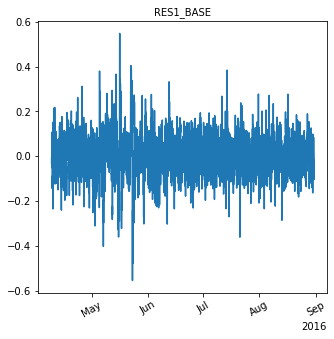

In [14]:
data_timeplot(Res1_base_7d)

In [16]:
# attention pour le test adfuller la valeur par défaut du lag = 12*(nobs)^0.25 = 36 est inférieur à la périodicité donc le test est bon même sans différentiation
# il faut prendre au minimum 7*48
import pprint
pp = pprint.PrettyPrinter(width=41, compact=True)

from statsmodels.tsa.stattools import adfuller
pp.pprint(adfuller(Res1_base_7d['RES1_BASE'][0:8000],400))

(-6.79155638432298,
 2.3575892546820558e-09, 387, 7612,
 {'1%': -3.4312093676528117,
  '10%': -2.566972150423357,
  '5%': -2.8619197762635364},
 -25975.96893380722)


In [16]:
import statsmodels.api as sm
model=sm.tsa.SARIMAX(data_slice(Res1_base,0,15),order=(1,1,1),seasonal_order=(1,1,1,48))
m_fitted=model.fit()
print(m_fitted.summary())

C:\Users\fred_\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency 30T will be used.
  % freq, ValueWarning)


                                 Statespace Model Results                                 
Dep. Variable:                          RES1_BASE   No. Observations:                  720
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 48)   Log Likelihood                1182.985
Date:                            Mon, 02 Mar 2020   AIC                          -2355.969
Time:                                    21:03:53   BIC                          -2333.425
Sample:                                04-01-2016   HQIC                         -2347.238
                                     - 04-15-2016                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4556      1.236      0.369      0.712      -1.967       2.878
ma.L1         -0.4729      1.227   

In [18]:
model=sm.tsa.SARIMAX(data_slice(Res1_base,0,15),order=(0,1,1),seasonal_order=(1,1,1,48))
m_fitted=model.fit()
print(m_fitted.summary())

C:\Users\fred_\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency 30T will be used.
  % freq, ValueWarning)


                                 Statespace Model Results                                 
Dep. Variable:                          RES1_BASE   No. Observations:                  720
Model:             SARIMAX(0, 1, 1)x(1, 1, 1, 48)   Log Likelihood                1182.905
Date:                            Mon, 02 Mar 2020   AIC                          -2357.811
Time:                                    21:07:35   BIC                          -2339.775
Sample:                                04-01-2016   HQIC                         -2350.825
                                     - 04-15-2016                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.L1         -0.0053      0.032     -0.166      0.868      -0.068       0.057
ar.S.L48       0.0856      0.043   

In [19]:
model=sm.tsa.SARIMAX(data_slice(Res1_base,0,15),order=(0,1,0),seasonal_order=(1,1,1,48))
m_fitted=model.fit()
print(m_fitted.summary())

C:\Users\fred_\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:165: ValueWarning: No frequency information was provided, so inferred frequency 30T will be used.
  % freq, ValueWarning)


                                 Statespace Model Results                                 
Dep. Variable:                          RES1_BASE   No. Observations:                  720
Model:             SARIMAX(0, 1, 0)x(1, 1, 1, 48)   Log Likelihood                1182.826
Date:                            Mon, 02 Mar 2020   AIC                          -2359.651
Time:                                    21:08:41   BIC                          -2346.125
Sample:                                04-01-2016   HQIC                         -2354.412
                                     - 04-15-2016                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.S.L48       0.0824      0.044      1.868      0.062      -0.004       0.169
ma.S.L48      -0.9580      0.123   